# Word2Vec with TensorFlow

Let's make some embeddings!

Just in case you want to make your own embeddings for the SOM. 

*Warning: Expensive tasks involved! Word2Vec is an expensive task and train a SOM with really high dimensional data is a REALLY HIGH expensive task. CURSE OF DIMENSIONALITY IS IN THE HOUSE!*

# Dependencies and utils

In [36]:
import tensorflow as tf
import math
import numpy as np
import collections
import codecs
import nltk
import re
import numpy as np
import pandas as pd
import time
import datetime


def read_data(filename):
    corpus_raw = u""
    with codecs.open(filename,'r','utf-8') as file:
        corpus_raw += file.read()
    return corpus_raw

def extract_words(corpus):
    clean = re.sub("[^a-zA-z]"," ",corpus)
    words = clean.split()
    return words

def extract_corpus_as_integers(corpus,vocab_to_id):
    words_as_int = []
    clean = re.sub("[^a-zA-z]"," ",corpus)
    words = clean.split()
    
    for word in words:
        words_as_int.append(vocab_to_id[word])
    
    return words_as_int

def create_dictionaries(unique_vocab):
    '''
    return: id_to_vocab,vocab_to_id
    '''
    id_to_vocab = {i:ch for i,ch in enumerate(unique_vocab)}
    vocab_to_id = {ch:i for i,ch in enumerate(unique_vocab)}
    return id_to_vocab,vocab_to_id

def generate_batch(data,batch_size=16,num_skips=1,skip_window=2):
    """Return batch and label from data
    args:
    data: A list of 'int' representing each word of the corpus (use extract_corpus_as_integers function)
    batch_size: The size of the batch (default 16)
    num_skips: How many times to reuse an input to generate a label (default 2)
    skip_window: How many words to consider left and right (default 1)
     
    """ 
    global data_index
    data_index = 0
    assert batch_size % num_skips == 0 
    assert num_skips < 2*skip_window 
    
    batch = np.ndarray(shape=(batch_size),dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1),dtype=np.int32)
    
    span = 2 * skip_window + 1 # Total length, target + context => [skip_window target skip_window]
    buffer = collections.deque(maxlen=span) #A list-like sequence with maxlen, if more appended, the first dissappears
    
    #Add the the words to buffer [skip_window target skip_window]
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    #A más skips menos vueltas
    for i in range(batch_size // num_skips): 
        target = skip_window #Target at the center
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):#For each skip
            while target in targets_to_avoid:
                target = np.random.randint(0,span-1)
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j,0] = buffer[target]
        
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    #Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch,labels

#TODO
def build_dataset(words, vocabulary_size):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

## Read and prepare data

In [5]:
FOLDER = ''
FILENAME = 'YOUR_TXT_FILENAME'
BUILD_DATASET = 'GOOGLE'

Generate corpus

In [12]:
if(BUILD_DATASET == 'ALBER'):
    raw_corpus = read_data(FOLDER+FILENAME)
    vocab = extract_words(corpus=raw_corpus)
    unique_vocab = set(vocab)
    vocabulary_size = len(unique_vocab)

    id_to_vocab,vocab_to_id = create_dictionaries(unique_vocab=unique_vocab)

    corpus = extract_corpus_as_integers(raw_corpus,vocab_to_id)

    print('All words: %d' % len(corpus))
    print('All unique words: %d' % vocabulary_size)
    
if(BUILD_DATASET == 'GOOGLE'):
    raw_corpus = read_data(FOLDER+FILENAME)
    vocab = extract_words(corpus=raw_corpus)
    
    corpus, count, vocab_to_id, id_to_vocab = build_dataset(vocab,1000)
    unique_vocab = vocab_to_id.keys()
    vocabulary_size = len(unique_vocab)
    
    print('All words: %d' % len(corpus))
    print('All unique words: %d' % vocabulary_size)

All words: 331572
All unique words: 1000


Few random vocabulary words

In [13]:
print('Part of the vocab:\n%s\n%s'%(list(unique_vocab)[0:10],list(unique_vocab)[len(id_to_vocab)-10:len(id_to_vocab)]))

Part of the vocab:
['Meera', 'days', 'cannot', 'Shagga', 'wide', 'be', 'After', 'castle', 'help', 'learn']
['love', 'Ned', 'answered', 'poor', 'Snow', 'north', 'doubt', 'dragon', 'young', 'twenty']


## Build the model

### Embeddings matrix

The embedding matrix is the matrix that will represent the vector representation of each word, so it has to be:

[vocabulary size x number features]

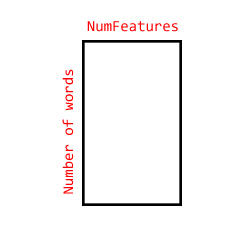

In [14]:
embedding_size = 300

embeddings = tf.Variable(tf.random_uniform(shape=[vocabulary_size,embedding_size],minval=-1.0,maxval=1.0))

### Out weights and biases

The NCE loss is defined in terms of a **logistic regression** model.

For this, we need to define the **weights** and **biases** for each **word**

In [15]:
nce_weights = tf.Variable(tf.truncated_normal(shape=[vocabulary_size,embedding_size],stddev=1.0/math.sqrt(embedding_size)))

nce_biases = tf.Variable(tf.zeros(shape=[vocabulary_size]))

## Skip-Gram model

### Placeholders

Note: Each word is represented as an integer (dict...)

The Skip-Gram model takes **two inputs:**

 - Batch full of integers representing the **source** context **words**
 - Batch full of integers representing the **target words**

In [16]:
batch_size = 16

train_inputs = tf.placeholder(dtype=tf.int32,shape=[batch_size],name='train_inputs')
train_labels = tf.placeholder(dtype=tf.int32,shape=[batch_size,1],name='train_labels')

Now he have to look up the vector for each of the source words, TF helps!

*tf.nn.embedding_lookup():* Looks up `ids` in a list of embedding tensors.

In [17]:
embed = tf.nn.embedding_lookup(embeddings,train_inputs)

### Loss

Let's try to **predict** the **target word** using the **NCE** objective

In [18]:
num_samples = 64 #The number of classes to randomly sample per batch

nce = tf.nn.nce_loss(weights=nce_weights,
                    biases=nce_biases,
                    labels=train_labels,
                    inputs=embed,
                    num_sampled=num_samples,
                    num_classes=vocabulary_size)


loss = tf.reduce_mean(nce)

And, of course, the **optimizer**

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

### Similarities

Have fun with some similarities

In [20]:
#Valid set
valid_size = 4     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

valid_dataset = tf.constant(valid_examples,dtype=tf.int32)

test_dataset = tf.placeholder(shape=[1],dtype=tf.int32,name='test_placeholder') #Word of your choose for testing

#For exporting embeddings
complete_dataset = tf. placeholder(shape=[vocabulary_size],dtype=tf.int32,name='test_placeholder') 

In [21]:
#Cosine similarity

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keep_dims=True))
normalized_embeddings = embeddings/norm

valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)

test_embeddings = tf.nn.embedding_lookup(normalized_embeddings,test_dataset)#For testing words of your choose

complete_embeddings = tf.nn.embedding_lookup(normalized_embeddings,complete_dataset)#For testing words of your choose



similarity = tf.matmul(valid_embeddings,normalized_embeddings,transpose_b=True)
test_similarity = tf.matmul(test_embeddings,normalized_embeddings,transpose_b=True)#For testing words of your choose


## Train the model

Feed data and run!

In [45]:
#If train equals False then last trained model will be restored if available
TRAIN = True

In [50]:
model_checkpoint = '.\SOM_GOT_W2V_Model.chkpt'
starting_time = datetime.datetime.now()
starting_hour = starting_time.hour
starting_minute = starting_time.minute
print('Starting training @ %d:%d' %(starting_hour,starting_minute))

if(TRAIN):
    start_time = time.time()
    epochs = 10001

    with tf.Session() as sess:
        average_loss = 0
        tf.global_variables_initializer().run()
        tf_saver = tf.train.Saver(tf.global_variables())

        for step in range(epochs):
            #TODO: Estimador de tiempo basado en las 10/100 primeras epochs

            #TIME
            if(step == 10):
                time_10 = (time.time() - start_time)/10
                seconds = float(epochs)*time_10
                timedelta = datetime.timedelta(seconds=seconds)
                final_time = starting_time + timedelta
                
                print('Estimated time based on 10 epochs: %.0f seconds - Approximate end time %d:%d' 
                      % (seconds,final_time.hour,final_time.minute))
                

            #Create batch
            inputs,labels = generate_batch(data=corpus,batch_size=batch_size)

            #Create feed dict from the returnnn of the generate_batch function
            feed = {train_inputs : inputs, train_labels : labels}

            #Perform update every step by evaluating optimizer op
            _,curr_loss = sess.run(fetches=[optimizer,loss],feed_dict=feed)

            average_loss += curr_loss

            #Show Average Loss info
            if(step % 2000 == 0 and step > 0):
                average_loss /= 2000 #AvLoss of last 2000 batches
                print('Average loss at step %d : %.2f - Elapsed time: %.1f' %(step,average_loss,(time.time() - start_time)))
                average_loss = 0

            #Show similarities
            if (step % 10000 == 0):
                print('Similarities at step %d :' %(step))     
                sim = similarity.eval()
                for i in range(valid_size):#The number of words to valid
                    valid_word = id_to_vocab[valid_examples[i]]
                    top_k = 8 #Number of nearest neighbours
                    nearest = sim[i,:].argsort()[1:top_k + 1]
                    log_str = "Nearest to %s:" % valid_word
                    for k in range(top_k):
                        close_word = id_to_vocab[nearest[k]]
                        log_str = "%s %s," % (log_str,close_word)
                    print(log_str)

            #Final embeddings
            final_embeddings = normalized_embeddings.eval()
            export_lookup_embeddings = complete_embeddings.eval(feed_dict={complete_dataset : list(id_to_vocab)})
            tf_saver.save(sess, model_checkpoint)

    print('Train finalized\nTotal elapsed time: %.1f seconds' %(time.time() - start_time))
else:
    print('No train choosed, trying to restore last model')
    with tf.Session() as sess:
        tf_saver = tf.train.Saver()
        tf_saver.restore(sess, model_checkpoint)
        export_lookup_embeddings = complete_embeddings.eval(feed_dict={complete_dataset : list(id_to_vocab)})
        

Starting training @ 13:31
Similarities at step 0 :
Nearest to out: enough, wore, die, along, fires, Grace, cried, Hall,
Nearest to and: bloody, serve, could, clever, grew, power, waited, now,
Nearest to from: death, alone, One, heard, Gendry, fine, sure, raven,
Nearest to up: sun, together, lay, Craster, Mormont, caught, wasn, stay,
Estimated time based on 10 epochs: 6317 seconds - Approximate end time 15:16
Average loss at step 2000 : nan - Elapsed time: 1153.0
Average loss at step 4000 : nan - Elapsed time: 2376.8
Average loss at step 6000 : nan - Elapsed time: 3578.5
Average loss at step 8000 : nan - Elapsed time: 4897.9
Average loss at step 10000 : nan - Elapsed time: 6337.0
Similarities at step 10000 :
Nearest to out: enough, wore, die, along, fires, Grace, cried, Hall,
Nearest to and: bloody, serve, could, clever, grew, power, waited, now,
Nearest to from: death, alone, One, heard, Gendry, fine, sure, raven,
Nearest to up: sun, together, lay, Craster, Mormont, caught, wasn, stay,

# Explore some results

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [52]:
print('There are %d words embeded in vector of %d dimensions' %(final_embeddings.shape[0],final_embeddings.shape[1]))

There are 1000 words embeded in vector of 300 dimensions


In [68]:
final_embeddings = final_embeddings[~np.isnan(final_embeddings)]
final_embeddings = final_embeddings.reshape(-1,300)
final_embeddings.shape

(996, 300)

**Plot**

In [72]:
plot_only = 900
labels = list(unique_vocab)[:plot_only]

if(final_embeddings.shape[1] > 2):
    tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
else:
    low_dim_embs = final_embeddings

In [73]:
print('Dimensionality Reduction finished')

Dimensionality Reduction finished


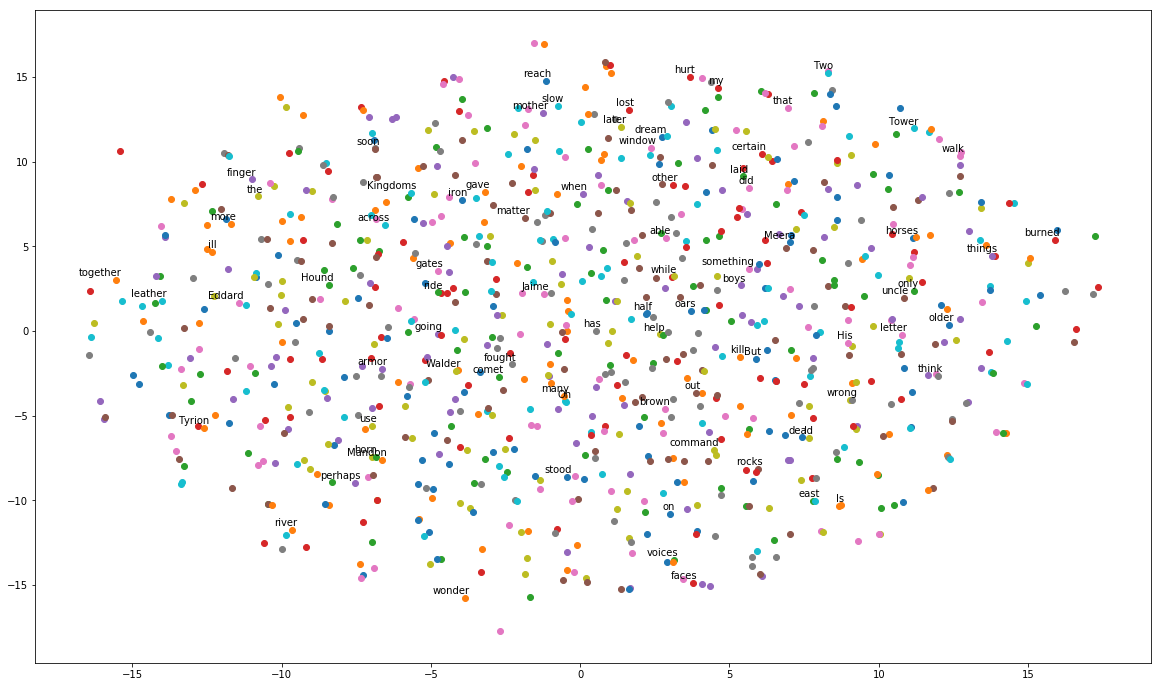

In [74]:
%matplotlib inline

plt.figure(figsize=(20,12))
for i,label in enumerate(labels):
    maybe_anotate = np.random.rand()
    x,y = low_dim_embs[i,:]
    plt.scatter(x,y)
    if(maybe_anotate < 0.1):
        plt.annotate(label,xy=(x,y),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
    
plt.show()

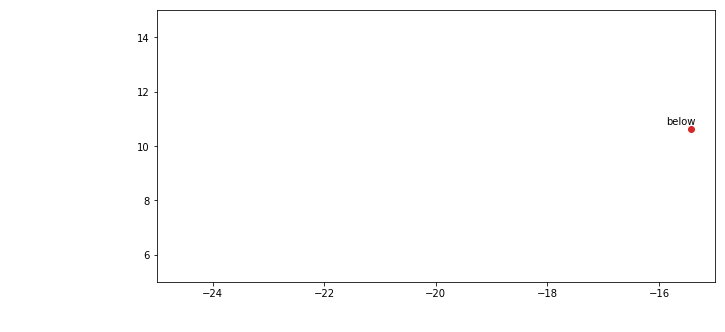

In [75]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.xlim(-25,-15)
plt.ylim(5,15)
for i,label in enumerate(labels):
    x,y = low_dim_embs[i,:]
    plt.scatter(x,y)
    plt.annotate(label,xy=(x,y),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
    
plt.show()

In [76]:
def most_k_similar_words(word,neighbours):
    with tf.Session() as sess:
        tf_saver = tf.train.Saver()
        tf_saver.restore(sess, model_checkpoint)

        sim = sess.run(test_similarity,feed_dict={test_dataset : [vocab_to_id[word]]})
                
        valid_word = word
        top_k = neighbours #Number of nearest neighbours
        nearest = sim[0,:].argsort()[1:top_k + 1]
        log_str = "Nearest to %s:" % valid_word
        for k in range(top_k):
            close_word = id_to_vocab[nearest[k]]
            log_str = "%s %s," % (log_str,close_word)
        print(log_str)

In [80]:
most_k_similar_words('Kingdoms',20)

Nearest to Kingdoms: Riverrun, too, angry, to, least, morning, here, fire, time, year, won, died, older, command, Once, eyes, late, comes, now, knees,


### Export embeddings

In [81]:
def export_embeddings_with_vocab():
    idx = 0
    display_freq = vocabulary_size//10
    f = open(FOLDER+'som_got_embedding_lookup.txt', 'w')

    for word,vector in zip(list(vocab_to_id),final_embeddings):
        if(idx % display_freq == 0):
            print('%d words already exported' % idx)
            
        vector = ' '.join(map(str, vector))
        
        #Write
        f.write(word+' '+vector+'\n')
        idx += 1
        
    f.close()     

In [82]:
export_embeddings_with_vocab()

0 words already exported
100 words already exported
200 words already exported
300 words already exported
400 words already exported
500 words already exported
600 words already exported
700 words already exported
800 words already exported
900 words already exported
